# Operating Room Scheduling

## Background

A hospital has six departments which require access to surgical facilities: General Surgery, Emergency,
Neuro-surgery, Opthamology, Oral Surgery, and Otolaryngology.
    
Each department currently shares a set of three operating rooms, and is currently allocated the following amount of total operating
room time (in hours per week): 

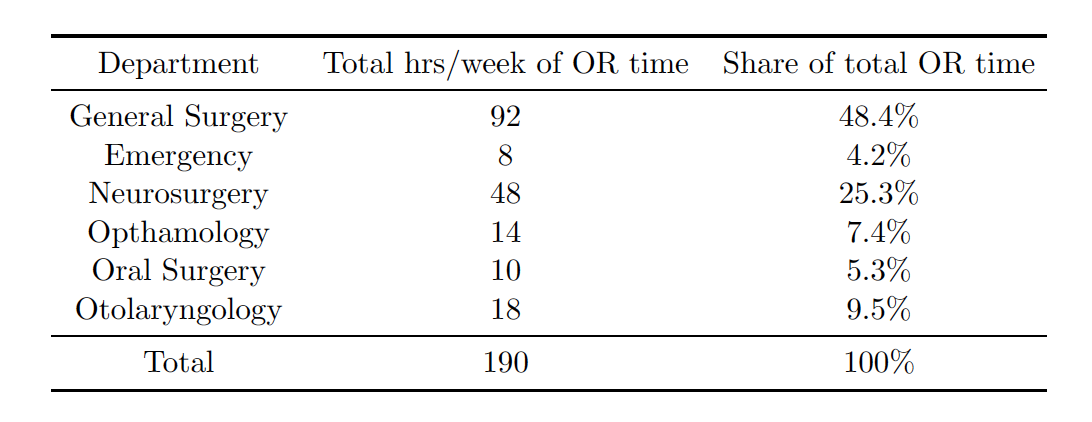

Next year, the hospital will be relocating to a larger hospital with five operating rooms. The new operating rooms will provide a total of 213.5 hours of operating room time per week (an increase from the current 190 hours per week). The availability of each room on each day of the week is
given in the table below:

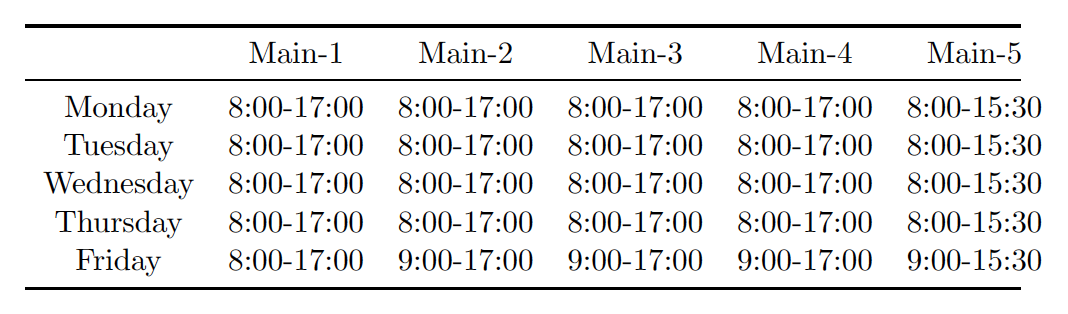

Moving to the new, larger hospital with more operating rooms means a new schedule must be devised. As a result, the hospital CEO has hired you to develop a new operating room schedule.

The main concern of the CEO is to find a schedule that is __*equitable*__. Specifically, she wants the new schedule to allocate slots to each department such that each department maintains its current
share (on a % basis) of the total operating room time. 

Additionally, there are a number of policies that are being considered, and you will be required to determine how each policy might potentially affect the fairness of the new schedule.

## Objectives

### A) 

First, formulate a schedule that **minimizes the total under-allocation of each department to operating rooms**. For example, General Surgery currently receives 48.4% of the total operating room time, and should therefore receive 48.4% of the total operating room time in the new schedule as well. In particular, the CEO has specified that under-allocation is to be avoided, meaning a penalty should be incurred if a department is allocated __less__ than its target %, but there should be no penalty if a department is allocated __more__ than its target % of operating room time. 

Your model should produce a new schedule that minimizes the total under-allocation (on a percentage basis). The reason for representing allocation on a percentage basis is that using units of time is not equitable: For example, a loss of 1 hour per week is much more disruptive to Oral Surgery (currently 10 hrs/week) than it is for General Surgery (92 hrs/week).

In [1]:
# Import gurobi, numpy and pandas
from gurobipy import *
import numpy as np
import pandas as pd

### Data 

In [19]:
# Define model and parameters. 
mod = Model()

current_hours = np.array([92, 8, 48, 14, 10, 18])
total_current_hours = np.sum(current_hours)


# We transpose this matrix because in x[i,j,k] j (rooms) describes rows and k (days) descibes columns
available_hours = np.transpose(np.array([[9, 9, 9, 9, 7.5],
                                         [9, 9, 9, 9, 7.5],
                                         [9, 9, 9, 9, 7.5],
                                         [9, 9, 9, 9, 7.5],
                                         [9, 8, 8, 8, 6.5]]))

total_target_hours = sum(sum(available_hours))
target_hours = current_hours / total_hours * target_total_hours

n_departments = current_hours.size
n_rooms = available_hours.shape[0]
n_days = available_hours.shape[1]

### Decision variables, constraints and objective function

In [ ]:
# Definition of decision variables 

s = mod.addVars(n_departments) # s[i] - hours of underallocation of i-th department
x = mod.addVars(n_departments, n_rooms, n_days, vtype = GRB.BINARY) # bianry variable x[i,j,k] = 1 if 
                                                        # i-th department takes a slot in j-th room at k-th day

In [20]:
# Constraints:

# Underallocation constraint:
mod.addConstrs(target_hours[i] - sum(x[i,j,k] * available_hours[j][k] \
               for j in range(n_rooms) for k in range(n_days)) <= s[i] \
               for i in range(n_departments))

# Only one department cat take a slot in one room at one day
mod.addConstrs(sum(x[i,j,k] for i in range(n_departments)) == 1 \
               for j in range(n_rooms) for k in range(n_days))


# Construct objective to minimize underallocation 
mod.setObjective(sum(s[i] / target_hours[i] for i in range(n_departments)), GRB.MINIMIZE)

In [21]:
# Update and solve
mod.update()
mod.optimize()

Gurobi Optimizer version 9.0.0 build v9.0.0rc2 (mac64)
Optimize a model with 31 rows, 156 columns and 306 nonzeros
Model fingerprint: 0x2ff8fdb9
Variable types: 6 continuous, 150 integer (150 binary)
Coefficient statistics:
  Matrix range     [1e+00, 9e+00]
  Objective range  [1e-02, 1e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+02]
Found heuristic solution: objective 0.9750492
Presolve time: 0.00s
Presolved: 31 rows, 156 columns, 306 nonzeros
Variable types: 6 continuous, 150 integer (150 binary)

Root relaxation: objective 0.000000e+00, 46 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    0.00000    0    8    0.97505    0.00000   100%     -    0s
H    0     0                       0.4970302    0.00000   100%     -    0s
H    0     0                       0.3115166    0.00000   100%     -    0s
H    0     0             

In [22]:
# Retrieve optimal value and optimal solution
opt_val = mod.objval
print("Optimal cost:",opt_val)

Optimal cost: 0.05203135270225944


### The optimized schedule

In [23]:
result = np.zeros([departments, rooms, days])
for i in range(departments):
    for j in range(rooms):
        for k in range(days):
            result[i][j][k] = x[i,j,k].x
df1 = pd.DataFrame(result[0,:,:].astype(int), columns=['Mon', 'Tue', 'Wed', 'Thu', 'Fri'], \
                   index=['Main-1', 'Main-2', 'Main-3', 'Main-4', 'Main-5'])
df2 = pd.DataFrame(result[1,:,:].astype(int), columns=['Mon', 'Tue', 'Wed', 'Thu', 'Fri'], \
                   index=['Main-1', 'Main-2', 'Main-3', 'Main-4', 'Main-5'])
df3 = pd.DataFrame(result[2,:,:].astype(int), columns=['Mon', 'Tue', 'Wed', 'Thu', 'Fri'], \
                   index=['Main-1', 'Main-2', 'Main-3', 'Main-4', 'Main-5'])
df4 = pd.DataFrame(result[3,:,:].astype(int), columns=['Mon', 'Tue', 'Wed', 'Thu', 'Fri'], \
                   index=['Main-1', 'Main-2', 'Main-3', 'Main-4', 'Main-5'])
df5 = pd.DataFrame(result[4,:,:].astype(int), columns=['Mon', 'Tue', 'Wed', 'Thu', 'Fri'], \
                   index=['Main-1', 'Main-2', 'Main-3', 'Main-4', 'Main-5'])
df6 = pd.DataFrame(result[5,:,:].astype(int), columns=['Mon', 'Tue', 'Wed', 'Thu', 'Fri'], \
                   index=['Main-1', 'Main-2', 'Main-3', 'Main-4', 'Main-5'])

schedule = pd.concat([df1, df2, df3, df4, df5, df6], \
           keys=('General Surgery','Emergency','Neurosurgery', \
                 'Opthamology','Oral Surgery','Otolaryngology'))

schedule

Mon  Tue  Wed  Thu  Fri
General Surgery Main-1    1    1    1    1    1
                Main-2    0    1    0    1    0
                Main-3    1    0    0    1    0
                Main-4    1    0    0    0    0
                Main-5    0    0    0    0    0
Emergency       Main-1    0    0    0    0    0
                Main-2    0    0    1    0    0
                Main-3    0    0    0    0    0
                Main-4    0    0    0    0    0
                Main-5    0    0    0    0    0
Neurosurgery    Main-1    0    0    0    0    0
                Main-2    1    0    0    0    0
                Main-3    0    1    1    0    0
                Main-4    0    1    0    1    0
                Main-5    0    0    0    0    0
Opthamology     Main-1    0    0    0    0    0
                Main-2    0    0    0    0    0
                Main-3    0    0    0    0    0
                Main-4    0    0    0    0    1
                Main-5    0    0    0    0    0
Oral Surgery    Main-1    0    0    0    0    0
                Main-2    0    0    0    0    0
                Main-3    0    0    0    0    0
                Main-4    0    0    0    0    0
                Main-5    0    1    0    0    1
Otolaryngology  Main-1    0    0    0    0    0
                Main-2    0    0    0    0    0
                Main-3    0    0    0    0    0
                Main-4    0    0    0    0    0
                Main-5    1    0    1    1    0

In [24]:
obtained_hours = np.zeros(departments)
for i in range(departments):
    obtained_hours[i] = sum(result[i][j][k]*available_hours[j][k] for j in range(rooms) for k in range(days))
    
print(f'{"Department":<17}{"Hours Allocated":<20} \n')
for i in range(len(obtained_hours)):
    print(f'{np.unique([item[0] for item in schedule.index.values])[i]:<17} {obtained_hours[i]:6.2f}')

Department       Hours Allocated      

Emergency          98.00
General Surgery     9.00
Neurosurgery       54.00
Opthamology        16.00
Oral Surgery       14.00
Otolaryngology     22.50


In [25]:
print(f'{"Department":<17}{"Hours Targeted":<20} \n')
for i in range(len(target_hours)):
    print(f'{np.unique([item[0] for item in schedule.index.values])[i]:<17} {target_hours[i]:6.2f}')

Department       Hours Targeted       

Emergency         103.38
General Surgery     8.99
Neurosurgery       53.94
Opthamology        15.73
Oral Surgery       11.24
Otolaryngology     20.23


In [26]:
# Departments received more hours that targeted
print(f'{"Department":<17}{"Target Reached":<20} \n')

for i in range(len(target_hours)):
    print(f'{np.unique([item[0] for item in schedule.index.values])[i]:<17} {obtained_hours[i] > target_hours[i]}')

Department       Target Reached       

Emergency         False
General Surgery   True
Neurosurgery      True
Opthamology       True
Oral Surgery      True
Otolaryngology    True


In [27]:
# Checking that no departments took the same slot
np.sum(result, axis=0)

array([[1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.]])

In [28]:
# Underallocation hours per department

s_opt = [s[i].x for i in range(departments)]

print(f'{"Department":<17}{"Underallocation hours":<20} \n')

for i in range(len(s_opt)):
    print(f'{np.unique([item[0] for item in schedule.index.values])[i]:<17} {s_opt[i]:3.2f}')

Department       Underallocation hours 

Emergency         5.38
General Surgery   0.00
Neurosurgery      0.00
Opthamology       0.00
Oral Surgery      0.00
Otolaryngology    0.00


In [30]:
# Relative under-allocation percentage for departments
underalloc = s_opt/target_hours * 100

print(f'{"Department":<17}{"Underallocation/target hours in %":<20} \n')

for i in range(len(underalloc)):
    print(f'{np.unique([item[0] for item in schedule.index.values])[i]:<17} {underalloc[i]:3.2f}')

Department       Underallocation/target hours in % 

Emergency         5.20
General Surgery   0.00
Neurosurgery      0.00
Opthamology       0.00
Oral Surgery      0.00
Otolaryngology    0.00
